In [1]:
import os
import sys
base_dir = os.path.join("/home/jovyan/work/Corona/COVID-19")
sys.path.append(base_dir)
import model as md

In [22]:
merger = md.Merger(data_dir="data", load_from_raw=False, load_from_agg=True)

# Prediction with LinearRegression on logistic numbers

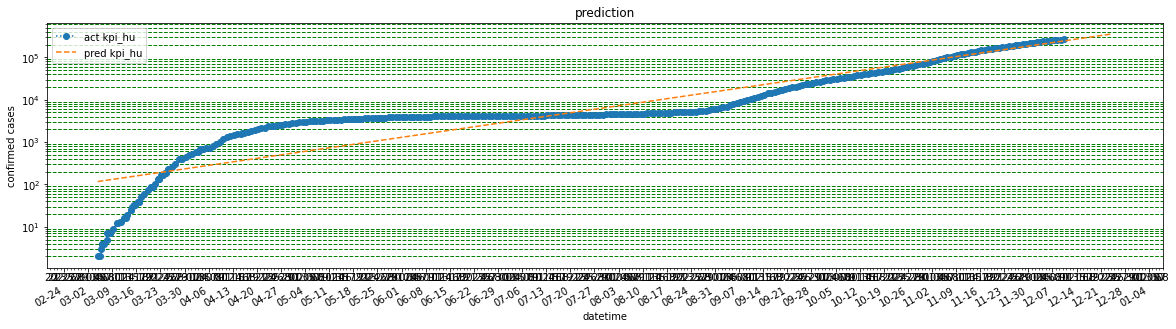

Coefficient of determination: {'kpi_hu': 0.8182175703468022}
Evolution factor per day: {'kpi_hu': 1.1}
Doubling in day(s): {'kpi_hu': 1.8181818181818181}


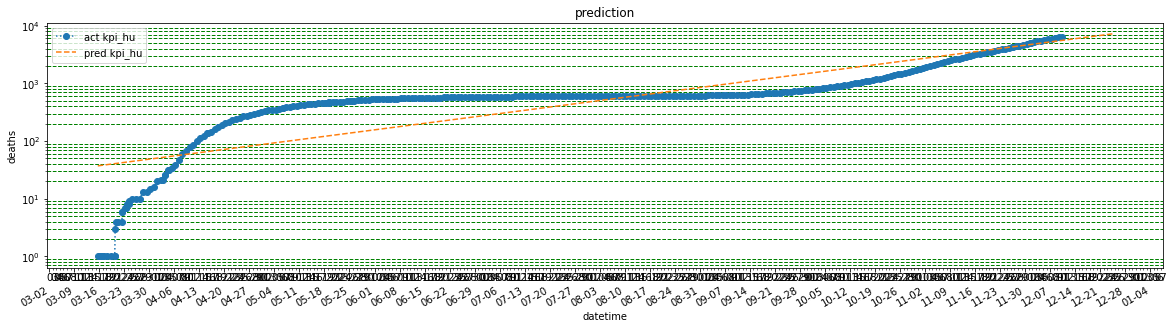

Coefficient of determination: {'kpi_hu': 0.6619364204201533}
Evolution factor per day: {'kpi_hu': 1.0}
Doubling in day(s): {'kpi_hu': 2.0}


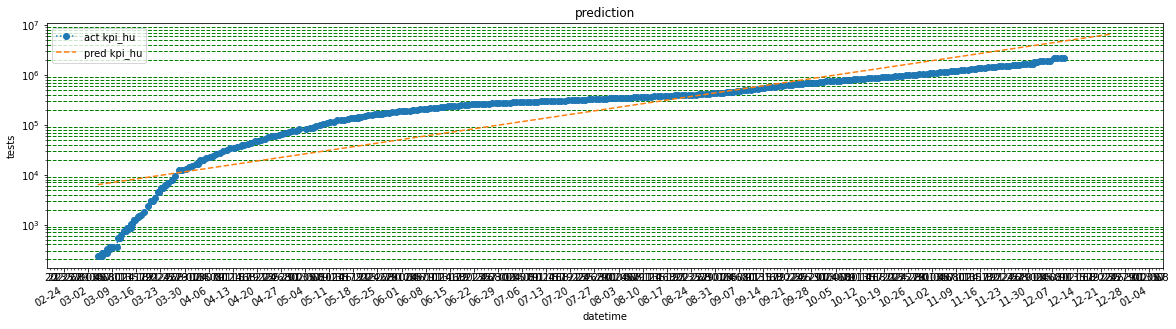

Coefficient of determination: {'kpi_hu': 0.7723608894164443}
Evolution factor per day: {'kpi_hu': 1.1}
Doubling in day(s): {'kpi_hu': 1.8181818181818181}


In [23]:
tmpDf = md.DataProcessing.Analyse.start_analyse(merger.show_kpi_hu(),["kpi_hu"],"confirmed cases", "infected")
tmpDf = md.DataProcessing.Analyse.start_analyse(merger.show_kpi_hu(),["kpi_hu"],"deaths", "deaths")
tmpDf = md.DataProcessing.Analyse.start_analyse(merger.show_kpi_hu(),["kpi_hu"],"tests", "tests")
#md.DataProcessing.Analyse.start_analyse(merger.show_kpi_hu(),["kpi_hu"],"recovered cases", "recovered")

In [24]:
from IPython.display import Math
Math(r'log(y) = a*x+b\\ \
     log(y_{2}) - log(y_{1}) = a*(x_{2}-x_{1})\\ \
     10^{log(y_{2}) - log(y_{1})} = 10^{a*(x_{2}-x_{1})}\\ \
     10^{log(y_{2})} / 10^{log(y_{1})} = 10^{a*(x_{2}-x_{1})}\\ \
     y_{2} / y_{1} = 10^{a*(x_{2}-x_{1})}')

<IPython.core.display.Math object>

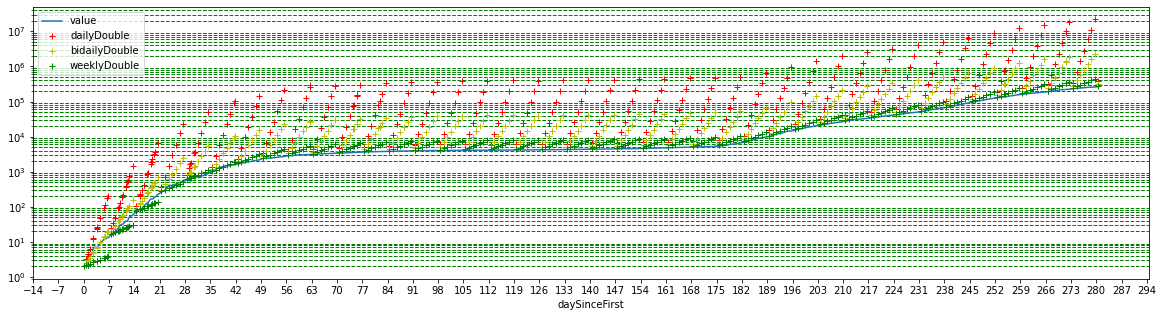

In [25]:
df = merger.show_kpi_hu()[["update","infected"]].copy()
#df = myProcessing.df["HU"][["update","deaths"]].copy()
df.columns = ["date","value"]

import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

def createDf(df, dayPerPeriod=5):
    # columns ["date","value"]
    df = df[df["value"]>0].copy()
    df["dayInt"] = df["date"].astype(int)/(10**9)/3600/24
    df["cycle"] = df["dayInt"].apply(lambda cell: int((cell - df["dayInt"].min()) / dayPerPeriod))
    df["dayStartOfCycle"] = df["dayInt"].apply(lambda cell: (cell - df["dayInt"].min()) % dayPerPeriod)
    df["valueStartOfCycle"] = df.apply(lambda row: df[df["cycle"]==row["cycle"]]["value"].min(), axis=1)
    df["daySinceFirst"] = df["dayInt"] - df["dayInt"].min()
    df["dailyDouble"] = df["valueStartOfCycle"] * (2**df["dayStartOfCycle"])
    df["bidailyDouble"] = df["valueStartOfCycle"] * (2**(df["dayStartOfCycle"] / 2))
    df["weeklyDouble"] = df["valueStartOfCycle"] * (2**(df["dayStartOfCycle"] / 7))
    del df["date"]
    del df["dayInt"]
    del df["dayStartOfCycle"]
    del df["valueStartOfCycle"]
    del df["cycle"]
    return df
def plotDf(df, dayPerPeriod=5):
    fig, ax = plt.subplots(figsize=(20, 5))
    ax.set_yscale("log")
    ax.grid(True, which="minor", axis="y", color='g', linestyle='--', linewidth=1)
    ax.grid(True, which="major", axis="y", color='g', linestyle='-', linewidth=2)
    ax.xaxis.set_major_locator(MultipleLocator(period))
    df.plot(x="daySinceFirst", y="value", ax=ax)
    df.plot(x="daySinceFirst", y="dailyDouble", ax=ax, style="r+")
    df.plot(x="daySinceFirst", y="bidailyDouble", ax=ax, style="y+")
    df.plot(x="daySinceFirst", y="weeklyDouble", ax=ax, style="g+")
    plt.show()
    
period = 7
df = createDf(df, dayPerPeriod=period)
plotDf(df, dayPerPeriod=period)

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
deaths_df = pd.read_json("data/deaths_hu/latest.json")
deaths_df["Nem"] = deaths_df["Nem"].apply(lambda cell: cell[0:1].capitalize() if isinstance(cell, str) else cell)
deaths_df["Korosztaly"] = deaths_df["Kor"] - deaths_df["Kor"] % 10
deaths_df.tail()
deaths_df[deaths_df["Kor"]<50]

,Sorszám,Nem,Kor,Alapbetegségek,Korosztaly
49,6402.0,N,21.0,"Hodgkin-limfóma, akut veseelégtelenség",20.0
116,6337.0,N,42.0,elhízás,40.0
139,6314.0,F,42.0,magasvérnyomás-betegség,40.0
147,6306.0,N,46.0,nem ismert alapbetegség,40.0
181,6273.0,N,46.0,"sclerosis multiplex, magasvérnyomás-betegség, ...",40.0
...,...,...,...,...,...
6471,106.0,F,46.0,"krónikus veseelégtelenség, szívelégtelenség, p...",40.0
6517,61.0,N,48.0,"krónikus veseelégtelenség, anyagcsere betegség...",40.0
6525,53.0,F,49.0,"magas vérnyomás, anyagcsere betegség",40.0
6572,7.0,F,38.0,"krónikus pancreatitis, alkoholos májkárosodás",30.0


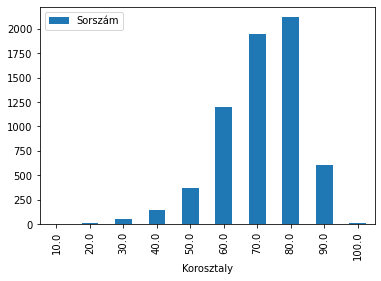

In [27]:
deaths_df.groupby(["Korosztaly"]).agg({"Sorszám":"count"}).plot(kind="bar")
plt.show()

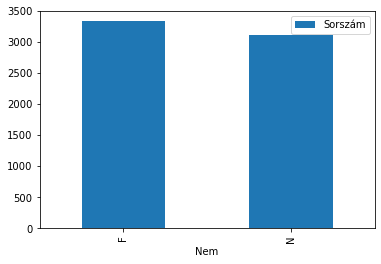

In [28]:
deaths_df.groupby(["Nem"]).agg({"Sorszám":"count"}).plot(kind="bar")
plt.show()

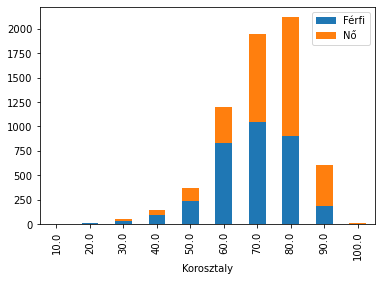

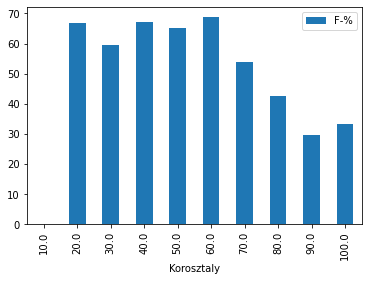

In [29]:
stats_df = deaths_df[deaths_df["Nem"]!=""].groupby(["Korosztaly","Nem"]).agg({"Sorszám":"count"}).unstack('Nem')
columns = ["Férfi","Nő"]
stats_df.columns = columns
stats_df["F-%"] = stats_df["Férfi"]/(stats_df["Férfi"]+stats_df["Nő"])*100
stats_df[columns].plot(kind="bar", stacked=True)
stats_df[["F-%"]].plot(kind="bar")
plt.show()

In [30]:
SIR = merger.show_kpi_hu()[["update","deaths","infected","recovered"]].copy()
SIR.columns = ["date","Deaths","Confirmed","Recovered"]
SIR["I"] = SIR["Confirmed"]-SIR["Deaths"]-SIR["Recovered"]
SIR["RD"] = SIR["Deaths"]+SIR["Recovered"]
SIR["D"] = SIR["Deaths"]
SIR.tail()

,date,Deaths,Confirmed,Recovered,I,RD,D
2020-12-06 08:54:00,2020-12-06 08:54:00,5868.0,250278.0,71682.0,172728.0,77550.0,5868.0
2020-12-07 11:43:00,2020-12-07 11:43:00,5984.0,254148.0,74283.0,173881.0,80267.0,5984.0
2020-12-08 08:40:00,2020-12-08 08:40:00,6120.0,256367.0,75281.0,174966.0,81401.0,6120.0
2020-12-09 08:48:00,2020-12-09 08:48:00,6280.0,259588.0,76270.0,177038.0,82550.0,6280.0
2020-12-10 08:50:00,2020-12-10 08:50:00,6451.0,265003.0,77362.0,181190.0,83813.0,6451.0


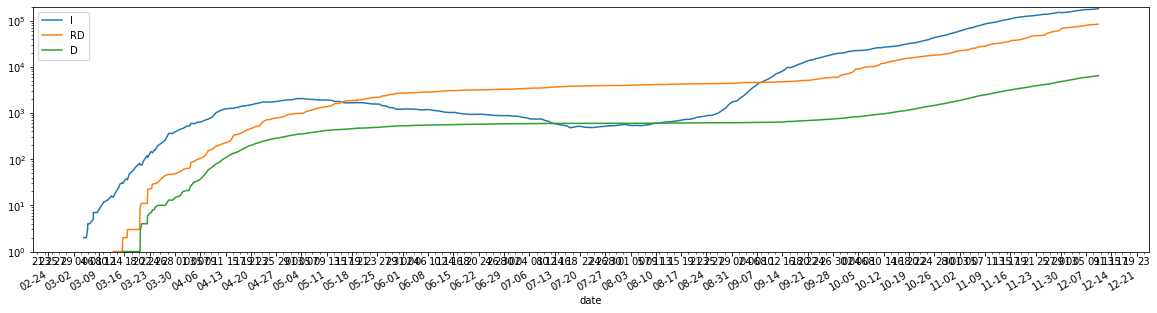

In [31]:
import matplotlib.dates as dates
fig, ax = plt.subplots(figsize=(20,5))

ax.xaxis.set_minor_locator(dates.DayLocator(bymonthday=range(1,32), interval=2))
ax.xaxis.set_minor_formatter(dates.DateFormatter('%d'))
ax.xaxis.set_major_locator(dates.WeekdayLocator(byweekday=0))
ax.xaxis.set_major_formatter(dates.DateFormatter('\n%m-%d'))
ax.set_yscale("log")
ax.set_ylim(1, 200000)

SIR.plot(x="date",y=["I","RD","D"],ax=ax)
plt.show()